# Multimodal Hate Speech Classification and Cyberbullying Detection

This notebook implements a multimodal model combining image and text features for hate speech detection and cyberbullying classification.

## Data Preprocessing


### Load Annotations and Prepare Data

In [1]:
import json
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
import re
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Input, Embedding, LSTM, Dropout, GlobalAveragePooling2D, Concatenate
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# Load the annotations
with open('/kaggle/input/multimodal-hate-speech/MMHS150K_GT.json', 'r') as f:
    annotations = json.load(f)


In [3]:
# Convert the JSON dict to a DataFrame
data = []
for tweet_id, info in annotations.items():
    data.append({
        'tweet_id': tweet_id,
        'tweet_text': info['tweet_text'],
        'labels': info['labels'],
        'labels_str': info['labels_str']
    })

df = pd.DataFrame(data)

# Add Image Path and Create Majority Label

In [4]:

# Path to the image folder
image_folder = '/kaggle/input/multimodal-hate-speech/img_resized'

In [5]:
# Add image path column
df['image_path'] = df['tweet_id'].apply(lambda x: os.path.join(image_folder, f"{x}.jpg"))


In [6]:
# Define majority vote function for labels
from collections import Counter

def majority_vote(labels):
    label_count = Counter(labels)
    return label_count.most_common(1)[0][0]

In [7]:
# Apply majority vote to create a single label column
df['majority_label'] = df['labels'].apply(majority_vote)

label_mapping = {
    0: "NotHate",
    1: "Racist",
    2: "Sexist",
    3: "Homophobe",
    4: "Religion",
    5: "OtherHate"
}

In [8]:
# Create a new column 'majority_label_str' with the string representation of the majority label
df['majority_label_str'] = df['majority_label'].map(label_mapping)


In [9]:
df.head()

,tweet_id,tweet_text,labels,labels_str,image_path,majority_label,majority_label_str
0,1114679353714016256,@FriskDontMiss Nigga https://t.co/cAsaLWEpue,"[4, 1, 3]","[Religion, Racist, Homophobe]",/kaggle/input/multimodal-hate-speech/img_resiz...,4,Religion
1,1063020048816660480,My horses are retarded https://t.co/HYhqc6d5WN,"[5, 5, 5]","[OtherHate, OtherHate, OtherHate]",/kaggle/input/multimodal-hate-speech/img_resiz...,5,OtherHate
2,1108927368075374593,“NIGGA ON MA MOMMA YOUNGBOY BE SPITTING REAL S...,"[0, 0, 0]","[NotHate, NotHate, NotHate]",/kaggle/input/multimodal-hate-speech/img_resiz...,0,NotHate
3,1114558534635618305,RT xxSuGVNGxx: I ran into this HOLY NIGGA TODA...,"[1, 0, 0]","[Racist, NotHate, NotHate]",/kaggle/input/multimodal-hate-speech/img_resiz...,0,NotHate
4,1035252480215592966,“EVERYbody calling you Nigger now!” https://t....,"[1, 0, 1]","[Racist, NotHate, Racist]",/kaggle/input/multimodal-hate-speech/img_resiz...,1,Racist


# Text Preprocessing

In [10]:
# Preprocess text data
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+|\#', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    return text

In [11]:
# Apply text preprocessing
df['cleaned_text'] = df['tweet_text'].apply(preprocess_text)


# Train-Test Splitting and Sampling

In [12]:
# Check the group sizes
df['majority_label'].value_counts()

majority_label
0    116790
1     14183
5      8196
2      5375
3      4926
4       353
Name: count, dtype: int64

In [13]:
# Get the minimum group size
min_group_size = df['majority_label'].value_counts().min()

In [14]:
# Define maximum samples per label for training and testing
train_samples_per_label = 1500
test_samples_per_label = 250

In [15]:
# Sample up to 1500 rows per label for training
train_data = (
    df.groupby('majority_label', group_keys=False)
    .apply(lambda x: x.sample(min(len(x), train_samples_per_label), random_state=42))
    .reset_index(drop=True)
)

# Use up to 250 rows per label for testing
remaining_data = df.loc[~df.index.isin(train_data.index)]
test_data = (
    remaining_data.groupby('majority_label', group_keys=False)
    .apply(lambda x: x.sample(min(len(x), test_samples_per_label), random_state=42))
    .reset_index(drop=True)
)


/tmp/ipykernel_30/3425876492.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(min(len(x), train_samples_per_label), random_state=42))
/tmp/ipykernel_30/3425876492.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(min(len(x), test_samples_per_label), random_state=42))


In [16]:
# Print the sizes of train and test sets
print("Training data size:", train_data.shape)
print("Testing data size:", test_data.shape)

Training data size: (7853, 8)
Testing data size: (1500, 8)


In [17]:
# Tokenize text
tokenizer = Tokenizer(num_words=20000, oov_token="<OOV>")
tokenizer.fit_on_texts(train_data['cleaned_text'])
X_train_text = pad_sequences(tokenizer.texts_to_sequences(train_data['cleaned_text']), maxlen=100)
X_test_text = pad_sequences(tokenizer.texts_to_sequences(test_data['cleaned_text']), maxlen=100)

In [18]:
# Load and preprocess images
def load_and_preprocess_image(img_path, target_size=(224, 224)):
    try:
        if not os.path.exists(img_path):
            return np.zeros((target_size[0], target_size[1], 3))
        img = load_img(img_path, target_size=target_size)
        img = img_to_array(img) / 255.0
        return img
    except Exception as e:
        return np.zeros((target_size[0], target_size[1], 3))

In [19]:
X_train_image = np.array([load_and_preprocess_image(path) for path in train_data['image_path']])
X_test_image = np.array([load_and_preprocess_image(path) for path in test_data['image_path']])

In [20]:
X_train_image.shape

(7853, 224, 224, 3)

In [21]:
# Labels
y_train = np.array(train_data['majority_label'])
y_test = np.array(test_data['majority_label'])

# Model Building: Multimodal Model

## Image Model

In [22]:
# Define image model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False

image_input = Input(shape=(224, 224, 3))
x_image = base_model(image_input, training=False)
x_image = GlobalAveragePooling2D()(x_image)
x_image = Dense(256, activation='relu')(x_image)
x_image = Dropout(0.5)(x_image)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## Text Model

In [23]:
# Define text model
text_input = Input(shape=(100,))
x_text = Embedding(input_dim=20000, output_dim=128, input_length=100)(text_input)
x_text = LSTM(128, return_sequences=False)(x_text)
x_text = Dense(128, activation='relu')(x_text)
x_text = Dropout(0.5)(x_text)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


## Combined Multimodal Model

In [24]:
# Combine image and text features
combined = Concatenate()([x_image, x_text])
x_combined = Dense(128, activation='relu')(combined)
x_combined = Dropout(0.5)(x_combined)
output = Dense(len(label_mapping), activation='softmax')(x_combined)

In [25]:
# Build model
multimodal_model = Model(inputs=[image_input, text_input], outputs=output)
multimodal_model.compile(optimizer=Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [26]:
# Print Model Summary
multimodal_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ input_layer_1[0]… │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 100, 128)  │  2,560,000 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 128)       │    131,584 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    524,544 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     16,512 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 384)       │          0 │ dropout[0][0],    │
│ (Concatenate)       │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │     49,280 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 6)         │        774 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 26,870,406 (102.50 MB)

 Trainable params: 3,282,694 (12.52 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

# Training the Model

In [27]:
# Train the model
history = multimodal_model.fit(
    [X_train_image, X_train_text], y_train,
    validation_data=([X_test_image, X_test_text], y_test),
    epochs=15,
    batch_size=32,
    verbose=1
)

Epoch 1/15
246/246 ━━━━━━━━━━━━━━━━━━━━ 40s 125ms/step - accuracy: 0.1863 - loss: 1.9720 - val_accuracy: 0.1687 - val_loss: 1.8253
Epoch 2/15
246/246 ━━━━━━━━━━━━━━━━━━━━ 26s 104ms/step - accuracy: 0.1986 - loss: 1.7436 - val_accuracy: 0.3113 - val_loss: 1.7429
Epoch 3/15
246/246 ━━━━━━━━━━━━━━━━━━━━ 26s 104ms/step - accuracy: 0.3399 - loss: 1.5516 - val_accuracy: 0.4373 - val_loss: 1.5532
Epoch 4/15
246/246 ━━━━━━━━━━━━━━━━━━━━ 25s 103ms/step - accuracy: 0.4480 - loss: 1.3902 - val_accuracy: 0.4407 - val_loss: 1.4687
Epoch 5/15
246/246 ━━━━━━━━━━━━━━━━━━━━ 25s 104ms/step - accuracy: 0.4841 - loss: 1.2885 - val_accuracy: 0.4547 - val_loss: 1.4562
Epoch 6/15
246/246 ━━━━━━━━━━━━━━━━━━━━ 25s 103ms/step - accuracy: 0.5050 - loss: 1.2266 - val_accuracy: 0.4833 - val_loss: 1.4202
Epoch 7/15
246/246 ━━━━━━━━━━━━━━━━━━━━ 26s 104ms/step - accuracy: 0.5285 - loss: 1.1472 - val_accuracy: 0.4820 - val_loss: 1.3777
Epoch 8/15
246/246 ━━━━━━━━━━━━━━━━━━━━ 25s 103ms/step - accuracy: 0.5792 - loss: 1

In [28]:
history0 = multimodal_model.fit(
    [X_train_image, X_train_text], y_train,
    validation_data=([X_test_image, X_test_text], y_test),
    epochs=5,
    batch_size=32,
    verbose=1
)

Epoch 1/5
246/246 ━━━━━━━━━━━━━━━━━━━━ 28s 113ms/step - accuracy: 0.7586 - loss: 0.6559 - val_accuracy: 0.5113 - val_loss: 1.4829
Epoch 2/5
246/246 ━━━━━━━━━━━━━━━━━━━━ 25s 104ms/step - accuracy: 0.7831 - loss: 0.6292 - val_accuracy: 0.5367 - val_loss: 1.4573
Epoch 3/5
246/246 ━━━━━━━━━━━━━━━━━━━━ 26s 104ms/step - accuracy: 0.7979 - loss: 0.5961 - val_accuracy: 0.5440 - val_loss: 1.5335
Epoch 4/5
246/246 ━━━━━━━━━━━━━━━━━━━━ 26s 104ms/step - accuracy: 0.8190 - loss: 0.5484 - val_accuracy: 0.5600 - val_loss: 1.5572
Epoch 5/5
246/246 ━━━━━━━━━━━━━━━━━━━━ 25s 103ms/step - accuracy: 0.8335 - loss: 0.5133 - val_accuracy: 0.5573 - val_loss: 1.5259


In [29]:
# Append additional history to the existing one
history.history['loss'] += history0.history['loss']
history.history['val_loss'] += history0.history['val_loss']
history.history['accuracy'] += history0.history['accuracy']
history.history['val_accuracy'] += history0.history['val_accuracy']

In [30]:
history0 = multimodal_model.fit(
    [X_train_image, X_train_text], y_train,
    validation_data=([X_test_image, X_test_text], y_test),
    epochs=5,
    batch_size=32,
    verbose=1
)

Epoch 1/5
246/246 ━━━━━━━━━━━━━━━━━━━━ 28s 113ms/step - accuracy: 0.8471 - loss: 0.4799 - val_accuracy: 0.5713 - val_loss: 1.5370
Epoch 2/5
246/246 ━━━━━━━━━━━━━━━━━━━━ 25s 103ms/step - accuracy: 0.8642 - loss: 0.4506 - val_accuracy: 0.5673 - val_loss: 1.6371
Epoch 3/5
246/246 ━━━━━━━━━━━━━━━━━━━━ 25s 103ms/step - accuracy: 0.8606 - loss: 0.4494 - val_accuracy: 0.5960 - val_loss: 1.6276
Epoch 4/5
246/246 ━━━━━━━━━━━━━━━━━━━━ 25s 103ms/step - accuracy: 0.8874 - loss: 0.4036 - val_accuracy: 0.5833 - val_loss: 1.6160
Epoch 5/5
246/246 ━━━━━━━━━━━━━━━━━━━━ 25s 103ms/step - accuracy: 0.8842 - loss: 0.3984 - val_accuracy: 0.5867 - val_loss: 1.7646


In [31]:
# Append additional history to the existing one
history.history['loss'] += history0.history['loss']
history.history['val_loss'] += history0.history['val_loss']
history.history['accuracy'] += history0.history['accuracy']
history.history['val_accuracy'] += history0.history['val_accuracy']

In [33]:
# Save the entire binary model
multimodal_model.save('multimodel_model.h5') 

In [34]:
# Evaluate the model
loss, accuracy = multimodal_model.evaluate([X_test_image, X_test_text], y_test, verbose=1)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - accuracy: 0.4687 - loss: 2.1709
Test Accuracy: 58.67%


# Binary Classification for Cyberbullying

## Modify and Retrain Model

In [37]:
# Map the labels to "cyberbully" or "not" based on 'majority_label_str' column
hate_labels = ['Racist', 'Sexist', 'Homophobe', 'Religion', 'OtherHate']

In [38]:
# Create a new binary label column based on whether the tweet belongs to hate speech
df['binary_label'] = df['majority_label_str'].apply(lambda x: 'cyberbully' if any(label in x for label in hate_labels) else 'not')


In [39]:
df.rename(columns={'binary_label': 'binary_label_str'}, inplace=True)

In [40]:
df['binary_label'] = df['binary_label_str'].apply(lambda x: 1 if x == 'cyberbully' else 0)

In [41]:
df.head()

,tweet_id,tweet_text,labels,labels_str,image_path,majority_label,majority_label_str,cleaned_text,binary_label_str,binary_label
0,1114679353714016256,@FriskDontMiss Nigga https://t.co/cAsaLWEpue,"[4, 1, 3]","[Religion, Racist, Homophobe]",/kaggle/input/multimodal-hate-speech/img_resiz...,4,Religion,nigga,cyberbully,1
1,1063020048816660480,My horses are retarded https://t.co/HYhqc6d5WN,"[5, 5, 5]","[OtherHate, OtherHate, OtherHate]",/kaggle/input/multimodal-hate-speech/img_resiz...,5,OtherHate,my horses are retarded,cyberbully,1
2,1108927368075374593,“NIGGA ON MA MOMMA YOUNGBOY BE SPITTING REAL S...,"[0, 0, 0]","[NotHate, NotHate, NotHate]",/kaggle/input/multimodal-hate-speech/img_resiz...,0,NotHate,nigga on ma momma youngboy be spitting real sh...,not,0
3,1114558534635618305,RT xxSuGVNGxx: I ran into this HOLY NIGGA TODA...,"[1, 0, 0]","[Racist, NotHate, NotHate]",/kaggle/input/multimodal-hate-speech/img_resiz...,0,NotHate,rt xxsugvngxx i ran into this holy nigga today,not,0
4,1035252480215592966,“EVERYbody calling you Nigger now!” https://t....,"[1, 0, 1]","[Racist, NotHate, Racist]",/kaggle/input/multimodal-hate-speech/img_resiz...,1,Racist,everybody calling you nigger now,cyberbully,1


In [42]:
from sklearn.utils import shuffle

In [43]:
# Function to balance dataset by sampling
def balance_classes(df, label_col, n_samples, random_state=42):
    class_0 = df[df[label_col] == 0].sample(n=n_samples, random_state=random_state)
    class_1 = df[df[label_col] == 1].sample(n=n_samples, random_state=random_state)
    return shuffle(pd.concat([class_0, class_1]), random_state=random_state)


In [44]:
# Create balanced datasets
balanced_df = balance_classes(df, 'binary_label', 4000)
balanced_df1 = balance_classes(df, 'binary_label', 500)

In [45]:
# Extract the features (text and images) and labels for train
X_binary_text_processed = pad_sequences(tokenizer.texts_to_sequences(balanced_df['cleaned_text']), maxlen=100)
X_binary_image_processed = np.array([load_and_preprocess_image(path) for path in balanced_df['image_path']])


In [54]:
y_binary = balanced_df['binary_label']

In [55]:
y_binary.shape

(8000,)

In [46]:
# Extract the features (text and images) and labels for text
X_test_binary_text_processed = pad_sequences(tokenizer.texts_to_sequences(balanced_df1['cleaned_text']), maxlen=100)
X_text_binary_image_processed = np.array([load_and_preprocess_image(path) for path in balanced_df1['image_path']])


In [56]:
y_test_binary = balanced_df1['binary_label']

In [57]:
y_test_binary.shape

(1000,)

In [47]:
X_binary_image_processed.shape

(8000, 224, 224, 3)

In [48]:
X_text_binary_image_processed.shape

(1000, 224, 224, 3)

In [49]:
from tensorflow.keras import layers, models

# Freeze all layers except the final one
for layer in multimodal_model.layers[:-1]:
    layer.trainable = False

# Add a new final layer for binary classification
binary_output = layers.Dense(1, activation='sigmoid')(multimodal_model.output)

# Create the binary model by combining the original multimodal model and the new final layer
binary_model = models.Model(inputs=multimodal_model.input, outputs=binary_output)

# Compile the binary model
binary_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [50]:
binary_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ input_layer_1[0]… │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 100, 128)  │  2,560,000 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 128)       │    131,584 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    524,544 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     16,512 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 384)       │          0 │ dropout[0][0],    │
│ (Concatenate)       │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │     49,280 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 6)         │        774 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 1)         │          7 │ dense_3[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 26,870,413 (102.50 MB)

 Trainable params: 781 (3.05 KB)

 Non-trainable params: 26,869,632 (102.50 MB)

In [58]:
# Train the binary model
history2 = binary_model.fit(
    [X_binary_image_processed, X_binary_text_processed], y_binary,
    validation_data=([X_text_binary_image_processed, X_test_binary_text_processed], y_test_binary),
    epochs=10,
    batch_size=32,
    verbose=1
)


Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 33s 108ms/step - accuracy: 0.5363 - loss: 0.6852 - val_accuracy: 0.7660 - val_loss: 0.5651
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 23s 94ms/step - accuracy: 0.6705 - loss: 0.6280 - val_accuracy: 0.8180 - val_loss: 0.5167
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 23s 94ms/step - accuracy: 0.6880 - loss: 0.6064 - val_accuracy: 0.8310 - val_loss: 0.4964
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 23s 93ms/step - accuracy: 0.6899 - loss: 0.6043 - val_accuracy: 0.8310 - val_loss: 0.4852
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 24s 94ms/step - accuracy: 0.7055 - loss: 0.5936 - val_accuracy: 0.8350 - val_loss: 0.4769
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 23s 94ms/step - accuracy: 0.7012 - loss: 0.5889 - val_accuracy: 0.8340 - val_loss: 0.4682
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 23s 94ms/step - accuracy: 0.6909 - loss: 0.5983 - val_accuracy: 0.8300 - val_loss: 0.4659
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 23s 94ms/step - accuracy: 0.6949 - loss: 0.5924 -

## Evaluation and Visualization

In [60]:
# Evaluate the model
loss, accuracy = binary_model.evaluate([X_text_binary_image_processed, X_test_binary_text_processed], y_test_binary, verbose=1)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - accuracy: 0.8340 - loss: 0.4580
Test Accuracy: 82.70%


In [64]:
# Save the entire binary model
binary_model.save('binary_model.h5') 

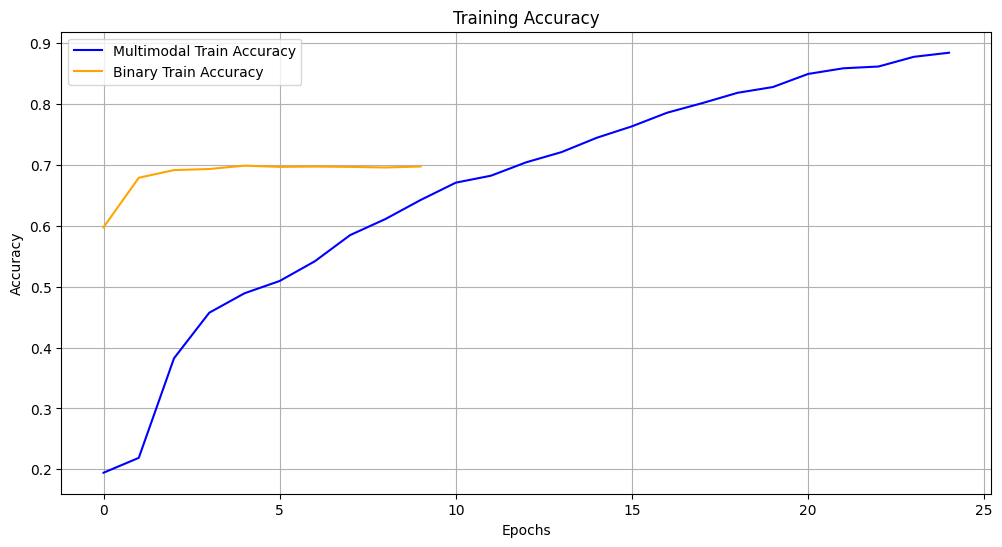

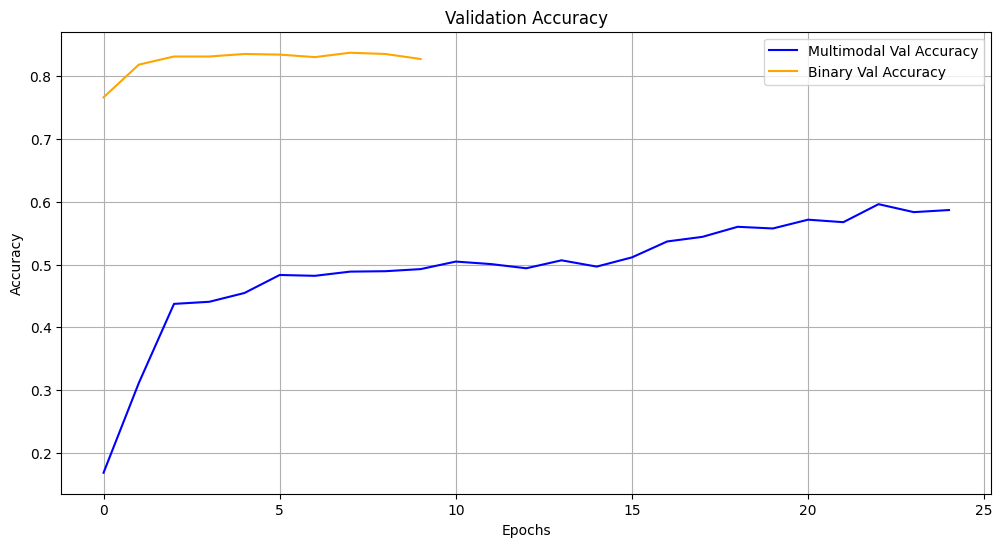

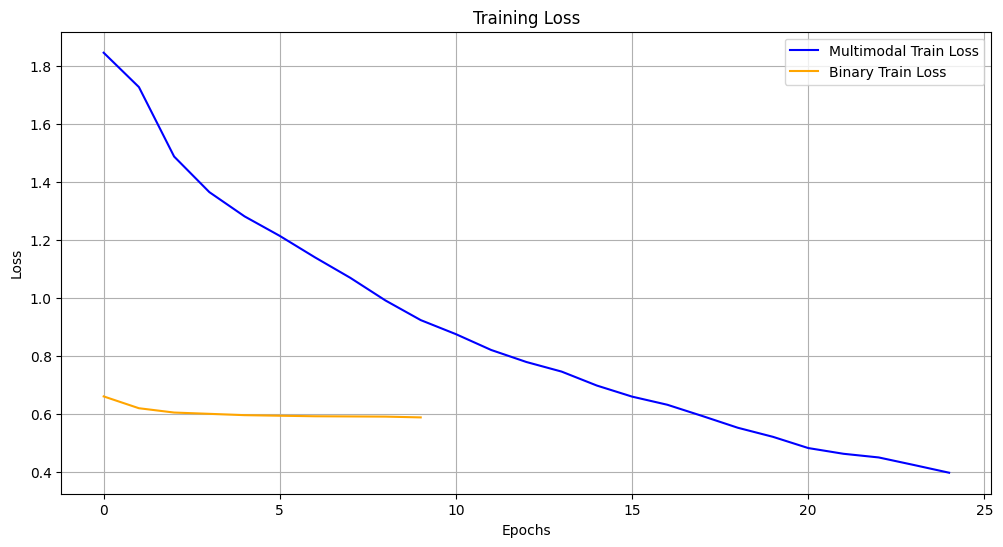

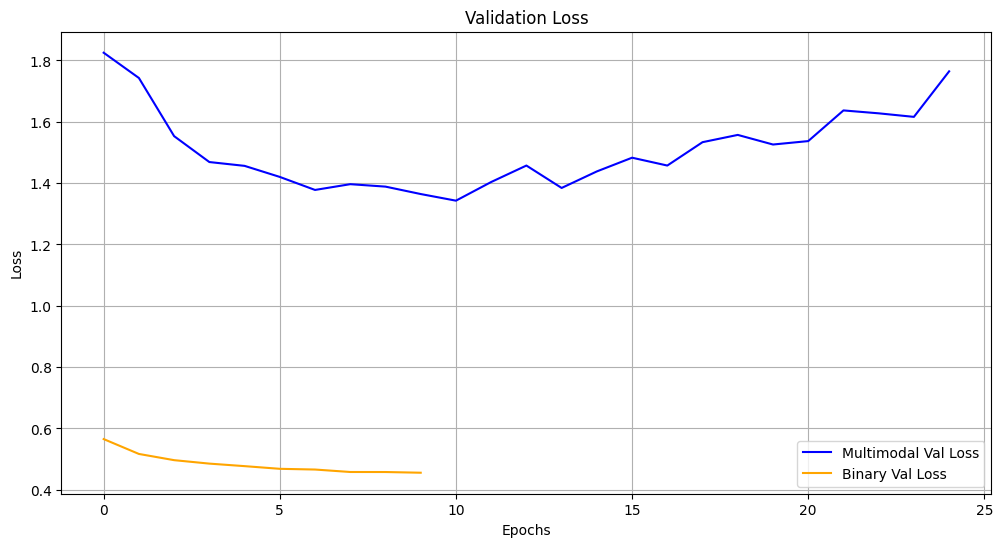

In [63]:
import matplotlib.pyplot as plt

# Training Accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Multimodal Train Accuracy', color='blue')
plt.plot(history2.history['accuracy'], label='Binary Train Accuracy', color='orange')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# Validation Accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['val_accuracy'], label='Multimodal Val Accuracy', color='blue')
plt.plot(history2.history['val_accuracy'], label='Binary Val Accuracy', color='orange')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# Training Loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Multimodal Train Loss', color='blue')
plt.plot(history2.history['loss'], label='Binary Train Loss', color='orange')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Validation Loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['val_loss'], label='Multimodal Val Loss', color='blue')
plt.plot(history2.history['val_loss'], label='Binary Val Loss', color='orange')
plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()


In [68]:
import random
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input


In [111]:
# Select 5 random indices from the entire dataset
random_indices = random.sample(range(len(df)), 5)

# Prepare the images and corresponding labels for visualization
images_to_show = []
true_labels = []
predicted_binary_labels = []
predicted_multimodal_labels = []

In [112]:
# Process images and get predictions
for idx in random_indices:
    # Get the image path from the dataset
    img_path = df['image_path'][idx]
    img = load_img(img_path, target_size=(224, 224))  # Resize image to fit model input size
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension (1, 224, 224, 3)
    img_array = preprocess_input(img_array)  # Preprocessing for ResNet50

    # Preprocess the text using the tokenizer (convert text to sequence)
    text_sequence = tokenizer.texts_to_sequences([df['cleaned_text'][idx]])
    text_padded = pad_sequences(text_sequence, maxlen=100)  # Adjust `maxlen` based on your model's input length

    images_to_show.append(img)
    true_labels.append(df['majority_label_str'][idx])  # True labels from the dataset for multimodal model

    # Get binary model prediction (for binary classification)
    binary_prediction = binary_model.predict([img_array, text_padded])
    binary_predicted_label = (binary_prediction > 0.5).astype(int)  # Binary classification: 0 or 1
    predicted_binary_labels.append(binary_predicted_label[0][0])  # Extracting the actual value

    # Get multimodal model prediction (for multimodal classification)
    multimodal_prediction = multimodal_model.predict([img_array, text_padded])
    multimodal_predicted_label = np.argmax(multimodal_prediction, axis=1)  # Multi-class classification
    predicted_multimodal_labels.append(multimodal_predicted_label[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


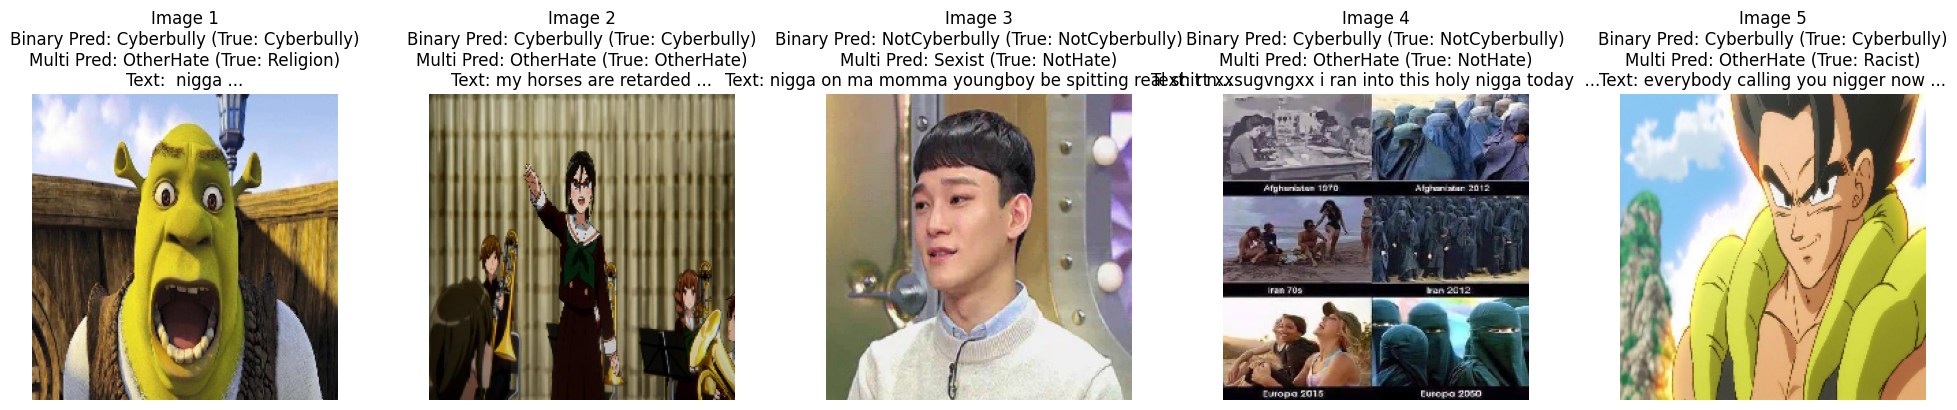

In [113]:
# Create the figure for displaying images and predictions
fig, axes = plt.subplots(1, 5, figsize=(20, 4))

# Label mappings for multimodal and binary models
multimodal_label_mapping = {
    0: "NotHate",
    1: "Racist",
    2: "Sexist",
    3: "Homophobe",
    4: "Religion",
    5: "OtherHate"
}

binary_label_mapping = {
    0: "NotCyberbully",
    1: "Cyberbully"
}

# Display images with their predictions from both models
for i, ax in enumerate(axes):
    ax.imshow(images_to_show[i])
    ax.axis('off')

    # Get the true label strings (from dataset)
    true_binary_label_str = binary_label_mapping[df['binary_label'][i]]  # Actual label for binary model
    true_multimodal_label_str = multimodal_label_mapping[df['majority_label'][i]]  # Actual label for multimodal model
    text_data = df['cleaned_text'][i]  # Text data corresponding to the image

    # Get the predicted labels (from models)
    binary_predicted_label = int(predicted_binary_labels[i])  # Convert to integer scalar for binary model
    multimodal_predicted_label = int(predicted_multimodal_labels[i])  # Convert to integer scalar for multimodal model

    # Get predicted label strings
    binary_predicted_label_str = binary_label_mapping[binary_predicted_label]
    multimodal_predicted_label_str = multimodal_label_mapping[multimodal_predicted_label]

    # Display the results on the image
    ax.set_title(f"Image {i+1}\nBinary Pred: {binary_predicted_label_str} (True: {true_binary_label_str})\n"
                 f"Multi Pred: {multimodal_predicted_label_str} (True: {true_multimodal_label_str})\n"
                 f"Text: {text_data[:50]}...")  # Show first 50 characters of the text for brevity

plt.tight_layout()
plt.show()
